In [1]:
import numpy as np
import pandas as pd
import math as m
import sys
import scipy.stats as stats
from scipy.spatial import distance
from matplotlib import pyplot as plt 
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
import random as rn

In [2]:
plt.style.use('../computermodernstyle.mplstyle')

In [3]:
def make_histogram(df, bins):
    n_data = df.shape
    bin_counts, bin_edges = np.histogram(df, bins=bins)
    bin_errors = bin_counts**0.5
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
    bin_widths = np.diff(bin_edges)

    # Normalization
    bin_counts_norm = bin_counts/n_data/bin_widths
    bin_errors_norm = bin_errors/n_data/bin_widths

    return bin_counts_norm, bin_errors_norm, bin_edges

In [4]:
def make_histogram_with_ratio(df, df_baseline, bins):
    bin_counts, bin_errors, bin_edges = make_histogram(df, bins)
    bin_counts_baseline, _, _ = make_histogram(df_baseline, bins)

    bin_counts_ratio = bin_counts/bin_counts_baseline
    bin_errors_ratio = bin_errors/bin_counts_baseline

    return bin_counts, bin_errors, bin_counts_ratio, bin_errors_ratio, bin_edges

In [5]:
select_model = 'best_validation'  # best_ess / best_validation / final

In [6]:
# Use the first file as baseline for ratio plot
file_names = ['../../ee_to_ttbar/data/unweighted_samples_phase_space.csv',
              '../../ee_to_ttbar/data/flow_samples_weighted_min_{}_phase_space.csv'.format(select_model),
              '../../ee_to_ttbar/data/flow_samples_weighted_max_{}_phase_space.csv'.format(select_model),
              '../../ee_to_ttbar/data/flow_samples_weighted_mean_{}_phase_space.csv'.format(select_model)]
names = [r"True", r"Weighted", r"Unweighted", r"Mean-weighted"]
edge_colours = ["#e41a1c", "#377eb8", "#4daf4a", "#984ea3", "#ff7f00", "#ffff33", "#a65628", "#f781bf"]

In [7]:
dfs = []
for name in file_names:
    dfs.append(pd.read_csv(name, delimiter = ',', header=None, index_col=False))

## Plot W mass

/home/bstienen/.local/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


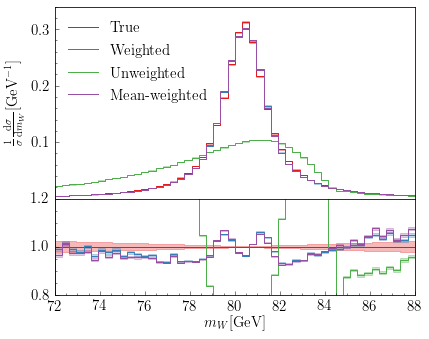

In [8]:
fig = plt.figure()
fig.set_size_inches(5,4)
gs = gridspec.GridSpec(nrows=3,ncols=1)
gs.update(left=0,right=1,top=1,bottom=0,hspace=0, wspace=0)

main_plot = fig.add_subplot(gs[:-1,0])
ratio_plot = fig.add_subplot(gs[2,0])

# Set bins
n_bins = 50
range_min = 72
range_max = 88

main_plot.set_xlim(range_min, range_max)
main_plot.set_ylim(0.0001, 0.34)
main_plot.set_xticks([])
ratio_plot.set_xlim(range_min, range_max)
ratio_plot.set_ylim(0.8,1.2)
bins = np.linspace(range_min, range_max, n_bins+1)
bin_centers = (bins[:-1] + bins[1:])/2

# Compute baseline observable
obs_baseline = np.sqrt((dfs[0][8] + dfs[0][12])**2 - (dfs[0][9] + dfs[0][13])**2 - (dfs[0][10] + dfs[0][14])**2 - (dfs[0][11] + dfs[0][15])**2)

for i in range(len(file_names)):
    # Compute observable
    df = dfs[i]
    obs = np.sqrt((df[8] + df[12])**2 - (df[9] + df[13])**2 - (df[10] + df[14])**2 - (df[11] + df[15])**2)
    
    # Get normalized histograms
    counts, errors, counts_ratio, errors_ratio, edges = make_histogram_with_ratio(obs, obs_baseline, bins)

    # Plot
    main_plot.hist(edges[:-1], edges, weights=counts, edgecolor=edge_colours[i], histtype="step", label=names[i])

    # Plot errors - Set up arrays for straight error filling
    fill_x = np.array([e for edge in bins for e in [edge, edge]][1:-1])
    fill_delta_y = np.array([y for error in errors for y in [error, error]])
    fill_central_y = np.array([c for count in counts for c in [count, count]])
    main_plot.fill_between(fill_x, fill_central_y-fill_delta_y, fill_central_y+fill_delta_y, color = edge_colours[i], alpha=0.3)

    # Plot ratios
    ratio_plot.hist(edges[:-1], edges, weights=counts_ratio, edgecolor=edge_colours[i], histtype="step")

    # Errors in ratios
    fill_x_ratio = np.array([e for edge in bins for e in [edge, edge]][1:-1])
    fill_delta_y_ratio = np.array([y for error in errors_ratio for y in [error, error]])
    fill_central_y_ratio = np.array([c for count in counts_ratio for c in [count, count]])
    ratio_plot.fill_between(fill_x_ratio, fill_central_y_ratio-fill_delta_y_ratio, fill_central_y_ratio+fill_delta_y_ratio, color = edge_colours[i], alpha=0.3)

handles, labels = main_plot.get_legend_handles_labels()
new_handles = [Line2D([], [], c=h.get_edgecolor()) for h in handles]
main_plot.legend(loc=2, handles=new_handles, labels=labels) 

ratio_plot.set_xlabel(r'$m_{W} [\mathrm{GeV}]$')
main_plot.set_ylabel(r'$\frac{1}{\sigma} \frac{\mathrm{d}\sigma}{\mathrm{d}m_{W}} [\mathrm{GeV}^{-1}]$')
plt.savefig('m_w.pdf', format='pdf', dpi=1000, bbox_inches = "tight")

## Plot top mass

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


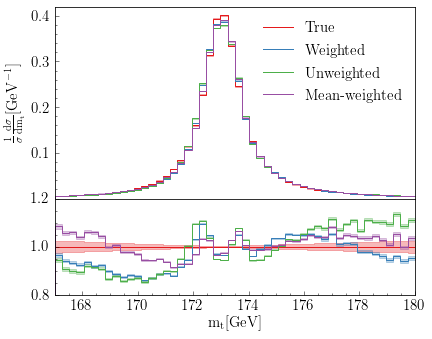

In [9]:
fig = plt.figure()
fig.set_size_inches(5,4)
gs = gridspec.GridSpec(nrows=3,ncols=1)
gs.update(left=0,right=1,top=1,bottom=0,hspace=0, wspace=0)

main_plot = fig.add_subplot(gs[:-1,0])
ratio_plot = fig.add_subplot(gs[2,0])

# Set bins
n_bins = 50
range_min = 167
range_max = 180

main_plot.set_xlim(range_min, range_max)
main_plot.set_ylim(0.0001, 0.42)
main_plot.set_xticks([])
ratio_plot.set_xlim(range_min, range_max)
ratio_plot.set_ylim(0.8,1.2)
bins = np.linspace(range_min, range_max, n_bins+1)
bin_centers = (bins[:-1] + bins[1:])/2

# Compute baseline mass
obs_baseline = np.sqrt((dfs[0][4] + dfs[0][8] + dfs[0][12])**2 - (dfs[0][5] + dfs[0][9] + dfs[0][13])**2 - (dfs[0][6] + dfs[0][10] + dfs[0][14])**2 - (dfs[0][7] + dfs[0][11] + dfs[0][15])**2)

for i in range(len(file_names)):
    # Compute mass of W
    df = dfs[i]
    obs = np.sqrt((df[4] + df[8] + df[12])**2 - (df[5] + df[9] + df[13])**2 - (df[6] + df[10] + df[14])**2 - (df[7] + df[11] + df[15])**2)
    
    # Get normalized histograms
    counts, errors, counts_ratio, errors_ratio, edges = make_histogram_with_ratio(obs, obs_baseline, bins)

    # Plot
    main_plot.hist(edges[:-1], edges, weights=counts, edgecolor=edge_colours[i], histtype="step", label=names[i])

    # Plot errors - Set up arrays for straight error filling
    fill_x = np.array([e for edge in bins for e in [edge, edge]][1:-1])
    fill_delta_y = np.array([y for error in errors for y in [error, error]])
    fill_central_y = np.array([c for count in counts for c in [count, count]])
    main_plot.fill_between(fill_x, fill_central_y-fill_delta_y, fill_central_y+fill_delta_y, color = edge_colours[i], alpha=0.3)

    # Plot ratios
    ratio_plot.hist(edges[:-1], edges, weights=counts_ratio, edgecolor=edge_colours[i], histtype="step")

    # Errors in ratios
    fill_x_ratio = np.array([e for edge in bins for e in [edge, edge]][1:-1])
    fill_delta_y_ratio = np.array([y for error in errors_ratio for y in [error, error]])
    fill_central_y_ratio = np.array([c for count in counts_ratio for c in [count, count]])
    ratio_plot.fill_between(fill_x_ratio, fill_central_y_ratio-fill_delta_y_ratio, fill_central_y_ratio+fill_delta_y_ratio, color = edge_colours[i], alpha=0.3)
    
handles, labels = main_plot.get_legend_handles_labels()
new_handles = [Line2D([], [], c=h.get_edgecolor()) for h in handles]
main_plot.legend(loc=1, handles=new_handles, labels=labels) 

ratio_plot.set_xlabel(r'$\mathrm{m_t} [\mathrm{GeV}]$')
main_plot.set_ylabel(r'$\frac{1}{\sigma} \mathrm{\frac{d\sigma}{dm_t}} [\mathrm{GeV}^{-1}]$')
plt.savefig('m_t.pdf', format='pdf', dpi=1000, bbox_inches = "tight")

## Plot W pT

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in subtract
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in subtract
/usr/

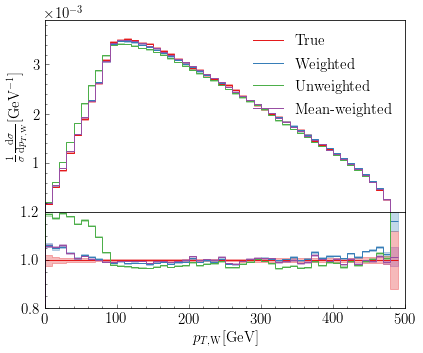

In [10]:
fig = plt.figure()
fig.set_size_inches(5,4)
gs = gridspec.GridSpec(nrows=3,ncols=1)
gs.update(left=0,right=1,top=1,bottom=0,hspace=0, wspace=0)

main_plot = fig.add_subplot(gs[:-1,0])
ratio_plot = fig.add_subplot(gs[2,0])

# Set bins
n_bins = 50
range_min = 0
range_max = 500

main_plot.set_xlim(range_min, range_max)
main_plot.set_ylim(0.00001, 0.0039)
main_plot.set_xticks([])
ratio_plot.set_xlim(range_min, range_max)
ratio_plot.set_ylim(0.8,1.2)
bins = np.linspace(range_min, range_max, n_bins+1)
bin_centers = (bins[:-1] + bins[1:])/2

# Compute baseline mass
obs_baseline = np.sqrt((dfs[0][9] + dfs[0][13])**2 + (dfs[0][10] + dfs[0][14])**2)

for i in range(len(file_names)):
    # Compute mass of W
    df = dfs[i]
    obs = np.sqrt((df[9] + df[13])**2 + (df[10] + df[14])**2)
    
    # Get normalized histograms
    counts, errors, counts_ratio, errors_ratio, edges = make_histogram_with_ratio(obs, obs_baseline, bins)

    # Plot
    main_plot.hist(edges[:-1], edges, weights=counts, edgecolor=edge_colours[i], histtype="step", label=names[i])

    # Plot errors - Set up arrays for straight error filling
    fill_x = np.array([e for edge in bins for e in [edge, edge]][1:-1])
    fill_delta_y = np.array([y for error in errors for y in [error, error]])
    fill_central_y = np.array([c for count in counts for c in [count, count]])
    main_plot.fill_between(fill_x, fill_central_y-fill_delta_y, fill_central_y+fill_delta_y, color = edge_colours[i], alpha=0.3)

    # Plot ratios
    ratio_plot.hist(edges[:-1], edges, weights=counts_ratio, edgecolor=edge_colours[i], histtype="step")

    # Errors in ratios
    fill_x_ratio = np.array([e for edge in bins for e in [edge, edge]][1:-1])
    fill_delta_y_ratio = np.array([y for error in errors_ratio for y in [error, error]])
    fill_central_y_ratio = np.array([c for count in counts_ratio for c in [count, count]])
    ratio_plot.fill_between(fill_x_ratio, fill_central_y_ratio-fill_delta_y_ratio, fill_central_y_ratio+fill_delta_y_ratio, color = edge_colours[i], alpha=0.3)
    
handles, labels = main_plot.get_legend_handles_labels()
new_handles = [Line2D([], [], c=h.get_edgecolor()) for h in handles]
main_plot.legend(loc=1, handles=new_handles, labels=labels) 

ratio_plot.set_xlabel(r'$p_{T,\mathrm{W}} [\mathrm{GeV}]$')
main_plot.set_ylabel(r'$\frac{1}{\sigma} \frac{\mathrm{d\sigma}}{\mathrm{d}p_{T,\mathrm{W}}} [\mathrm{GeV}^{-1}]$')
plt.savefig('wpt.pdf', format='pdf', dpi=1000, bbox_inches = "tight")

## Plot t phi

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


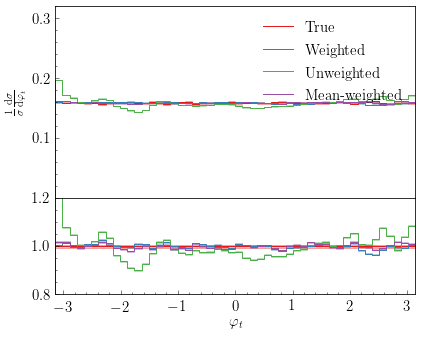

In [11]:
fig = plt.figure()
fig.set_size_inches(5,4)
gs = gridspec.GridSpec(nrows=3,ncols=1)
gs.update(left=0,right=1,top=1,bottom=0,hspace=0, wspace=0)

main_plot = fig.add_subplot(gs[:-1,0])
ratio_plot = fig.add_subplot(gs[2,0])

# Set bins
n_bins = 50
range_min = -3.14159265359
range_max = 3.14159265359

main_plot.set_xlim(range_min, range_max)
main_plot.set_ylim(0.00001, 0.32)
main_plot.set_xticks([])
ratio_plot.set_xlim(range_min, range_max)
ratio_plot.set_ylim(0.8,1.2)
bins = np.linspace(range_min, range_max, n_bins+1)
bin_centers = (bins[:-1] + bins[1:])/2

# Compute baseline mass
obs_baseline = np.arctan2(dfs[0][5] + dfs[0][9] + dfs[0][13], dfs[0][6] + dfs[0][10] + dfs[0][14])

for i in range(len(file_names)):
    # Compute mass of W
    df = dfs[i]
    obs = np.arctan2(df[5] + df[9] + df[13], df[6] + df[10] + df[14])
    
    # Get normalized histograms
    counts, errors, counts_ratio, errors_ratio, edges = make_histogram_with_ratio(obs, obs_baseline, bins)

    # Plot
    main_plot.hist(edges[:-1], edges, weights=counts, edgecolor=edge_colours[i], histtype="step", label=names[i])

    # Plot errors - Set up arrays for straight error filling
    fill_x = np.array([e for edge in bins for e in [edge, edge]][1:-1])
    fill_delta_y = np.array([y for error in errors for y in [error, error]])
    fill_central_y = np.array([c for count in counts for c in [count, count]])
    main_plot.fill_between(fill_x, fill_central_y-fill_delta_y, fill_central_y+fill_delta_y, color = edge_colours[i], alpha=0.3)

    # Plot ratios
    ratio_plot.hist(edges[:-1], edges, weights=counts_ratio, edgecolor=edge_colours[i], histtype="step")

    # Errors in ratios
    fill_x_ratio = np.array([e for edge in bins for e in [edge, edge]][1:-1])
    fill_delta_y_ratio = np.array([y for error in errors_ratio for y in [error, error]])
    fill_central_y_ratio = np.array([c for count in counts_ratio for c in [count, count]])
    ratio_plot.fill_between(fill_x_ratio, fill_central_y_ratio-fill_delta_y_ratio, fill_central_y_ratio+fill_delta_y_ratio, color = edge_colours[i], alpha=0.3)
    
handles, labels = main_plot.get_legend_handles_labels()
new_handles = [Line2D([], [], c=h.get_edgecolor()) for h in handles]
main_plot.legend(loc=1, handles=new_handles, labels=labels) 

ratio_plot.set_xlabel(r'$\varphi_{t}$')
main_plot.set_ylabel(r'$\frac{1}{\sigma} \frac{\mathrm{d}\sigma}{\mathrm{d}\varphi_{t}}$')
plt.savefig('phib.pdf', format='pdf', dpi=1000, bbox_inches = "tight")

## electron energy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


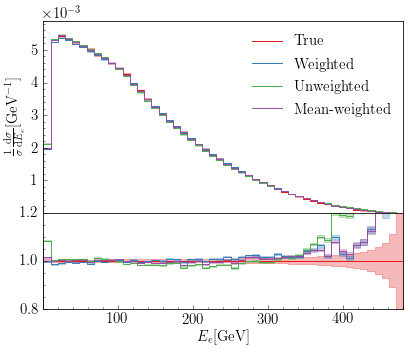

In [12]:
fig = plt.figure()
fig.set_size_inches(5,4)
gs = gridspec.GridSpec(nrows=3,ncols=1)
gs.update(left=0,right=1,top=1,bottom=0,hspace=0, wspace=0)

main_plot = fig.add_subplot(gs[:-1,0])
ratio_plot = fig.add_subplot(gs[2,0])

# Set bins
n_bins = 50
range_min = 1
range_max = 480

main_plot.set_xlim(range_min, range_max)
main_plot.set_ylim(0.00001, 0.0059)
main_plot.set_xticks([])
ratio_plot.set_xlim(range_min, range_max)
ratio_plot.set_ylim(0.8,1.2)
bins = np.linspace(range_min, range_max, n_bins+1)
bin_centers = (bins[:-1] + bins[1:])/2

# Compute baseline mass
obs_baseline = dfs[0][8]

for i in range(len(file_names)):
    # Compute mass of W
    df = dfs[i]
    obs = df[8]
    
    # Get normalized histograms
    counts, errors, counts_ratio, errors_ratio, edges = make_histogram_with_ratio(obs, obs_baseline, bins)

    # Plot
    main_plot.hist(edges[:-1], edges, weights=counts, edgecolor=edge_colours[i], histtype="step", label=names[i])

    # Plot errors - Set up arrays for straight error filling
    fill_x = np.array([e for edge in bins for e in [edge, edge]][1:-1])
    fill_delta_y = np.array([y for error in errors for y in [error, error]])
    fill_central_y = np.array([c for count in counts for c in [count, count]])
    main_plot.fill_between(fill_x, fill_central_y-fill_delta_y, fill_central_y+fill_delta_y, color = edge_colours[i], alpha=0.3)

    # Plot ratios
    ratio_plot.hist(edges[:-1], edges, weights=counts_ratio, edgecolor=edge_colours[i], histtype="step")

    # Errors in ratios
    fill_x_ratio = np.array([e for edge in bins for e in [edge, edge]][1:-1])
    fill_delta_y_ratio = np.array([y for error in errors_ratio for y in [error, error]])
    fill_central_y_ratio = np.array([c for count in counts_ratio for c in [count, count]])
    ratio_plot.fill_between(fill_x_ratio, fill_central_y_ratio-fill_delta_y_ratio, fill_central_y_ratio+fill_delta_y_ratio, color = edge_colours[i], alpha=0.3)
    
handles, labels = main_plot.get_legend_handles_labels()
new_handles = [Line2D([], [], c=h.get_edgecolor()) for h in handles]
main_plot.legend(loc=1, handles=new_handles, labels=labels) 

ratio_plot.set_xlabel(r'$E_{e} [\mathrm{GeV}]$')
main_plot.set_ylabel(r'$\frac{1}{\sigma} \frac{\mathrm{d}\sigma}{\mathrm{d}E_e} [\mathrm{GeV}^{-1}] $')
plt.savefig('Ee.pdf', format='pdf', dpi=1000, bbox_inches = "tight")

## bottom energy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


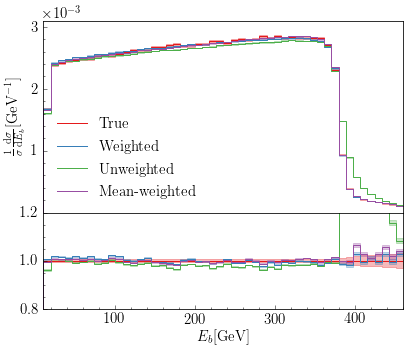

In [13]:
fig = plt.figure()
fig.set_size_inches(5,4)
gs = gridspec.GridSpec(nrows=3,ncols=1)
gs.update(left=0,right=1,top=1,bottom=0,hspace=0, wspace=0)

main_plot = fig.add_subplot(gs[:-1,0])
ratio_plot = fig.add_subplot(gs[2,0])

# Set bins
n_bins = 50
range_min = 10
range_max = 460

main_plot.set_xlim(range_min, range_max)
main_plot.set_ylim(0.000001, 3.1e-3)
main_plot.set_xticks([])
ratio_plot.set_xlim(range_min, range_max)
ratio_plot.set_ylim(0.8,1.2)
bins = np.linspace(range_min, range_max, n_bins+1)
bin_centers = (bins[:-1] + bins[1:])/2

# Compute baseline mass
obs_baseline = dfs[0][4]

for i in range(len(file_names)):
    # Compute mass of W
    df = dfs[i]
    obs = df[4]
    
    # Get normalized histograms
    counts, errors, counts_ratio, errors_ratio, edges = make_histogram_with_ratio(obs, obs_baseline, bins)

    # Plot
    main_plot.hist(edges[:-1], edges, weights=counts, edgecolor=edge_colours[i], histtype="step", label=names[i])

    # Plot errors - Set up arrays for straight error filling
    fill_x = np.array([e for edge in bins for e in [edge, edge]][1:-1])
    fill_delta_y = np.array([y for error in errors for y in [error, error]])
    fill_central_y = np.array([c for count in counts for c in [count, count]])
    main_plot.fill_between(fill_x, fill_central_y-fill_delta_y, fill_central_y+fill_delta_y, color = edge_colours[i], alpha=0.3)

    # Plot ratios
    ratio_plot.hist(edges[:-1], edges, weights=counts_ratio, edgecolor=edge_colours[i], histtype="step")

    # Errors in ratios
    fill_x_ratio = np.array([e for edge in bins for e in [edge, edge]][1:-1])
    fill_delta_y_ratio = np.array([y for error in errors_ratio for y in [error, error]])
    fill_central_y_ratio = np.array([c for count in counts_ratio for c in [count, count]])
    ratio_plot.fill_between(fill_x_ratio, fill_central_y_ratio-fill_delta_y_ratio, fill_central_y_ratio+fill_delta_y_ratio, color = edge_colours[i], alpha=0.3)

handles, labels = main_plot.get_legend_handles_labels()
new_handles = [Line2D([], [], c=h.get_edgecolor()) for h in handles]
main_plot.legend(loc=3, handles=new_handles, labels=labels) 

ratio_plot.set_xlabel(r'$E_{b} [\mathrm{GeV}]$')
main_plot.set_ylabel(r'$\frac{1}{\sigma} \frac{\mathrm{d}\sigma}{\mathrm{d}E_{b}} [\mathrm{GeV}^{-1}] $')
plt.savefig('Eb.pdf', format='pdf', dpi=1000, bbox_inches = "tight")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


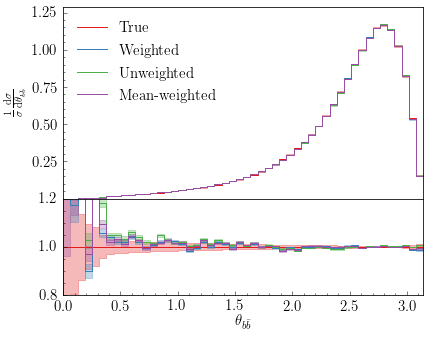

In [14]:
fig = plt.figure()
fig.set_size_inches(5,4)
gs = gridspec.GridSpec(nrows=3,ncols=1)
gs.update(left=0,right=1,top=1,bottom=0,hspace=0, wspace=0)

main_plot = fig.add_subplot(gs[:-1,0])
ratio_plot = fig.add_subplot(gs[2,0])

# Set bins
n_bins = 50
range_min = 0
range_max = 3.1415

main_plot.set_xlim(range_min, range_max)
main_plot.set_ylim(0.000001, 1.29)
main_plot.set_xticks([])
ratio_plot.set_xlim(range_min, range_max)
ratio_plot.set_ylim(0.8,1.2)
bins = np.linspace(range_min, range_max, n_bins+1)
bin_centers = (bins[:-1] + bins[1:])/2

# Compute baseline mass
obs_baseline = np.arccos(1. - (dfs[0][0]*dfs[0][4] - dfs[0][1]*dfs[0][5] - dfs[0][2]*dfs[0][6] - dfs[0][3]*dfs[0][7])/dfs[0][0]/dfs[0][4])

for i in range(len(file_names)):
    # Compute mass of W
    df = dfs[i]
    obs = np.arccos(1. - (df[0]*df[4] - df[1]*df[5] - df[2]*df[6] - df[3]*df[7])/df[0]/df[4])
    
    # Get normalized histograms
    counts, errors, counts_ratio, errors_ratio, edges = make_histogram_with_ratio(obs, obs_baseline, bins)

    # Plot
    main_plot.hist(edges[:-1], edges, weights=counts, edgecolor=edge_colours[i], histtype="step", label=names[i])

    # Plot errors - Set up arrays for straight error filling
    fill_x = np.array([e for edge in bins for e in [edge, edge]][1:-1])
    fill_delta_y = np.array([y for error in errors for y in [error, error]])
    fill_central_y = np.array([c for count in counts for c in [count, count]])
    main_plot.fill_between(fill_x, fill_central_y-fill_delta_y, fill_central_y+fill_delta_y, color = edge_colours[i], alpha=0.3)

    # Plot ratios
    ratio_plot.hist(edges[:-1], edges, weights=counts_ratio, edgecolor=edge_colours[i], histtype="step")

    # Errors in ratios
    fill_x_ratio = np.array([e for edge in bins for e in [edge, edge]][1:-1])
    fill_delta_y_ratio = np.array([y for error in errors_ratio for y in [error, error]])
    fill_central_y_ratio = np.array([c for count in counts_ratio for c in [count, count]])
    ratio_plot.fill_between(fill_x_ratio, fill_central_y_ratio-fill_delta_y_ratio, fill_central_y_ratio+fill_delta_y_ratio, color = edge_colours[i], alpha=0.3)

handles, labels = main_plot.get_legend_handles_labels()
new_handles = [Line2D([], [], c=h.get_edgecolor()) for h in handles]
main_plot.legend(loc=2, handles=new_handles, labels=labels) 

ratio_plot.set_xlabel(r'$\theta_{b \bar{b}}$')
main_plot.set_ylabel(r'$\frac{1}{\sigma} \frac{\mathrm{d}\sigma}{\mathrm{d}\theta_{b \bar{b}}} $')
plt.savefig('Thetabb.pdf', format='pdf', dpi=1000, bbox_inches = "tight")